This notebook is based on<br>https://github.com/yandexdataschool/Practical_RL/blob/master/week03_model_free/seminar_qlearning.ipynb and<br>https://github.com/yandexdataschool/Practical_RL/blob/master/week03_model_free/homework.ipynb

## Q-learning

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        value = np.max([self.get_qvalue(state, action) for action in possible_actions])

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        new_value = (1 - learning_rate) * self.get_qvalue(state, action) + learning_rate * (reward + gamma * self.get_value(next_state))

        self.set_qvalue(state, action, new_value)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        best_action_idx = np.argmax([self.get_qvalue(state, action) for action in possible_actions])

        best_action = possible_actions[best_action_idx]

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        rng = np.random.default_rng()
        random_u = rng.uniform(0,1)
        action = rng.choice(possible_actions)
        chosen_action = action if random_u <= epsilon else self.get_best_action(state)

        return chosen_action

### Try it on taxi

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [6]:
import gym
env = gym.make("Taxi-v3")

n_actions = env.action_space.n

In [7]:
agent = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

In [8]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

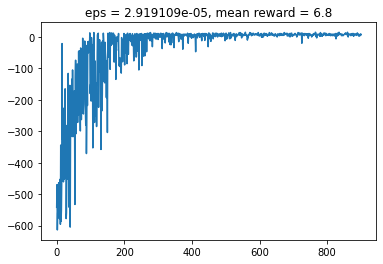

In [9]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        plt.title('eps = {:e}, mean reward = {:.1f}'.format(agent.epsilon, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()

# Binarized state spaces

Use agent to train efficiently on `CartPole-v0`. This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x, n_digits)` (or `np.round`) to round a real number to a given amount of digits. The tricky part is to get the `n_digits` right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

In [ ]:
def make_env():
    return gym.make('CartPole-v0').env  # .env unwraps the TimeLimit wrapper

env = make_env()
n_actions = env.action_space.n

print("first state: %s" % (env.reset()))
plt.imshow(env.render('rgb_array'))

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

In [ ]:
def visualize_cartpole_observation_distribution(seen_observations):
    seen_observations = np.array(seen_observations)
    
    # The meaning of the observations is documented in
    # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

    f, axarr = plt.subplots(2, 2, figsize=(16, 9), sharey=True)
    for i, title in enumerate(['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Velocity At Tip']):
        ax = axarr[i // 2, i % 2]
        ax.hist(seen_observations[:, i], bins=20)
        ax.set_title(title)
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(min(xmin, -xmax), max(-xmin, xmax))
        ax.grid()
    f.tight_layout()

In [ ]:
seen_observations = []
for _ in range(1000):
    seen_observations.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        seen_observations.append(s)

visualize_cartpole_observation_distribution(seen_observations)

## Binarize environment

In [ ]:
from gym.core import ObservationWrapper


class Binarizer(ObservationWrapper):
    def observation(self, state):
        # Hint: you can do that with round(x, n_digits).
        # You may pick a different n_digits for each dimension.
        state = <YOUR CODE: round state to some amount digits>

        return tuple(state)

In [ ]:
env = Binarizer(make_env())

In [ ]:
seen_observations = []
for _ in range(1000):
    seen_observations.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        seen_observations.append(s)
        if done:
            break

visualize_cartpole_observation_distribution(seen_observations)

## Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__

* Note that increasing the number of digits for one dimension of the observations increases your state space by a factor of $10$.
* If your binarization is too fine-grained, your agent will take much longer than 10000 steps to converge. You can either increase the number of iterations and reduce epsilon decay or change binarization. In practice we found that this kind of mistake is rather frequent.
* If your binarization is too coarse, your agent may fail to find the optimal policy. In practice we found that on this particular environment this kind of mistake is rare.
* **Start with a coarse binarization** and make it more fine-grained if that seems necessary.
* Having $10^3$–$10^4$ distinct states is recommended (`len(agent._qvalues)`), but not required.
* If things don't work without annealing $\varepsilon$, consider adding that, but make sure that it doesn't go to zero too quickly.

A reasonable agent should attain an average reward of at least 50.

In [ ]:
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

In [ ]:
agent = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

In [ ]:
rewards = []
epsilons = []

for i in range(10000):
    reward = play_and_train(env, agent)
    rewards.append(reward)
    epsilons.append(agent.epsilon)
    
    # OPTIONAL: <YOUR CODE: adjust epsilon>

    if i % 100 == 0:
        rewards_ewma = moving_average(rewards)
        
        clear_output(True)
        plt.plot(rewards, label='rewards')
        plt.plot(rewards_ewma, label='rewards ewma@100')
        plt.legend()
        plt.grid()
        plt.title('eps = {:e}, rewards ewma@100 = {:.1f}'.format(agent.epsilon, rewards_ewma[-1]))
        plt.show()

In [ ]:
print('Your agent has learned {} Q-values.'.format(len(agent._qvalues)))

# SARSA

Now we gonna implement Expected Value SARSA on top of it.

In [ ]:
class EVSarsaAgent(QLearningAgent):
    """ 
    An agent that changes some of q-learning functions to implement Expected Value SARSA. 
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        <YOUR CODE: see docstring>

        return state_value

### Cliff World

Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/cliffworld.png width=600>
<center><i>image by cs188</i></center>

In [ ]:
import gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n

print(env.__doc__)

In [ ]:
# Our cliffworld has one difference from what's on the image: there is no wall.
# Agent can choose to go as close to the cliff as it wishes. x:start, T:exit, C:cliff, o: flat ground
env.render()

In [ ]:
agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

In [ ]:
from IPython.display import clear_output

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

Let's now see what did the algorithms learn by visualizing their actions at every state.

In [ ]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " % actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [ ]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Explain the results. Why the algorithms learned such policies?

<< Your explanation >>

# Experience replay

There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: [spoiler] Experience replay :)

The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=480>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer. 
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [ ]:
import random


class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size

        # OPTIONAL: YOUR CODE

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (state, action, reward, next_state, done)

        # add data to storage
        <YOUR CODE>

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        states_batch: np.array
            batch of observations
        actions_batch: np.array
            batch of actions executed given obs_batch
        rewards_batch: np.array
            rewards received as results of executing act_batch
        next_states_batch: np.array
            next set of observations seen after executing act_batch
        done: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = <YOUR CODE: randomly generate batch_size integers to be used as indexes of samples>

        # collect <s,a,r,s',done> for each index
        <YOUR CODE>

        return (
            np.array( <YOUR CODE: states> ),
            np.array( <YOUR CODE: actions> ),
            np.array( <YOUR CODE: rewards> ),
            np.array( <YOUR CODE: next_states> ),
            np.array( <YOUR CODE: done>,
        )

Some tests to make sure your buffer works right

In [ ]:
def obj2arrays(obj):
    for x in obj:
        yield np.array([x])

def obj2sampled(obj):
    return tuple(obj2arrays(obj))

replay = ReplayBuffer(2)
obj1 = (0, 1, 2, 3, True)
obj2 = (4, 5, 6, 7, False)
replay.add(*obj1)
assert replay.sample(1) == obj2sampled(obj1), \
    "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay) == 2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay) == 2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj2)
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100)) == 2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj1)
print("Success!")

Now let's use this buffer to improve training:

In [ ]:
env = gym.make("Taxi-v3")
n_actions = env.action_space.n

In [ ]:
def play_and_train_with_replay(env, agent, replay=None,
                               t_max=10**4, replay_batch_size=32):
    """
    This function should 
    - run a full game, actions given by agent.get_action(s)
    - train agent using agent.update(...) whenever possible
    - return total reward
    :param replay: ReplayBuffer where agent can store and sample (s,a,r,s',done) tuples.
        If None, do not use experience replay
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s
        a = <YOUR CODE>

        next_s, r, done, _ = env.step(a)

        # update agent on current transition. Use agent.update
        <YOUR CODE>

        if replay is not None:
            # store current <s,a,r,s'> transition in buffer
            <YOUR CODE>

            # sample replay_batch_size random transitions from replay,
            # then update agent on each of them in a loop
            s_, a_, r_, next_s_, done_ = replay.sample(replay_batch_size)
            for i in range(replay_batch_size):
                <YOUR CODE>

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [ ]:
# Create two agents: first will use experience replay, second will not.

agent_baseline = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

agent_replay = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

replay = ReplayBuffer(1000)

In [ ]:
from IPython.display import clear_output

rewards_replay, rewards_baseline = [], []

for i in range(1000):
    rewards_replay.append(
        play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(
        play_and_train_with_replay(env, agent_baseline, replay=None))

    agent_replay.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('Baseline : eps =', agent_replay.epsilon,
              'mean reward =', np.mean(rewards_baseline[-10:]))
        print('ExpReplay: eps =', agent_baseline.epsilon,
              'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(moving_average(rewards_replay), label='exp. replay')
        plt.plot(moving_average(rewards_baseline), label='baseline')
        plt.grid()
        plt.legend()
        plt.show()

#### What to expect:

Experience replay, if implemented correctly, will improve algorithm's initial convergence a lot, but it shouldn't affect the final performance.